In [1]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']= 300
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [2]:
## 1 ##
def harmonic(x,y,eps):                      ## harmonic pde
    return [y[1], y[0]*(x**2 - eps)]

L = 4
xspan = np.linspace(-L, L, int(20*L + 1))
eps_start = 0
eigs_n = np.zeros(5)                        ## stores eig vals
phi_n = np.zeros((int(20*L + 1), 5))             ## stores phi_n

for j in range(5):                          ## mode loop
    eps = eps_start
    deps = 1
    for i in range(2000):
        y0 = [1, np.sqrt(L**2 - eps)]
        sol = sp.integrate.solve_ivp(harmonic, [-L, L], y0, args = (eps,), t_eval = xspan)

        bc_true = sol.y[1,-1]                           ##  "true" right bc
        bc_calc = -sol.y[0,-1]*np.sqrt(L**2 - eps)      ##  calculated right bc
        
        if np.abs(bc_true - bc_calc) < 1e-6:
            eigs_n[j] = eps
            phi_n[:,j] = sol.y[0,:]/np.sqrt(sp.integrate.trapz((sol.y[0,:])**2, xspan))
            break
        elif ((-1)**j)*(bc_true - bc_calc) > 0:
            eps = eps + deps
        else:
            eps = eps - deps/2
            deps = deps/2
    eps_start = eps + 0.8                                   ## jumps up over found eigval


A1 = np.abs(phi_n[:,0].reshape(-1,1))
A2 = np.abs(phi_n[:,1].reshape(-1,1))
A3 = np.abs(phi_n[:,2].reshape(-1,1))
A4 = np.abs(phi_n[:,3].reshape(-1,1))
A5 = np.abs(phi_n[:,4].reshape(-1,1))
A6 = eigs_n.reshape(1,-1)

In [3]:
A6[0,1]

2.9990026018213483

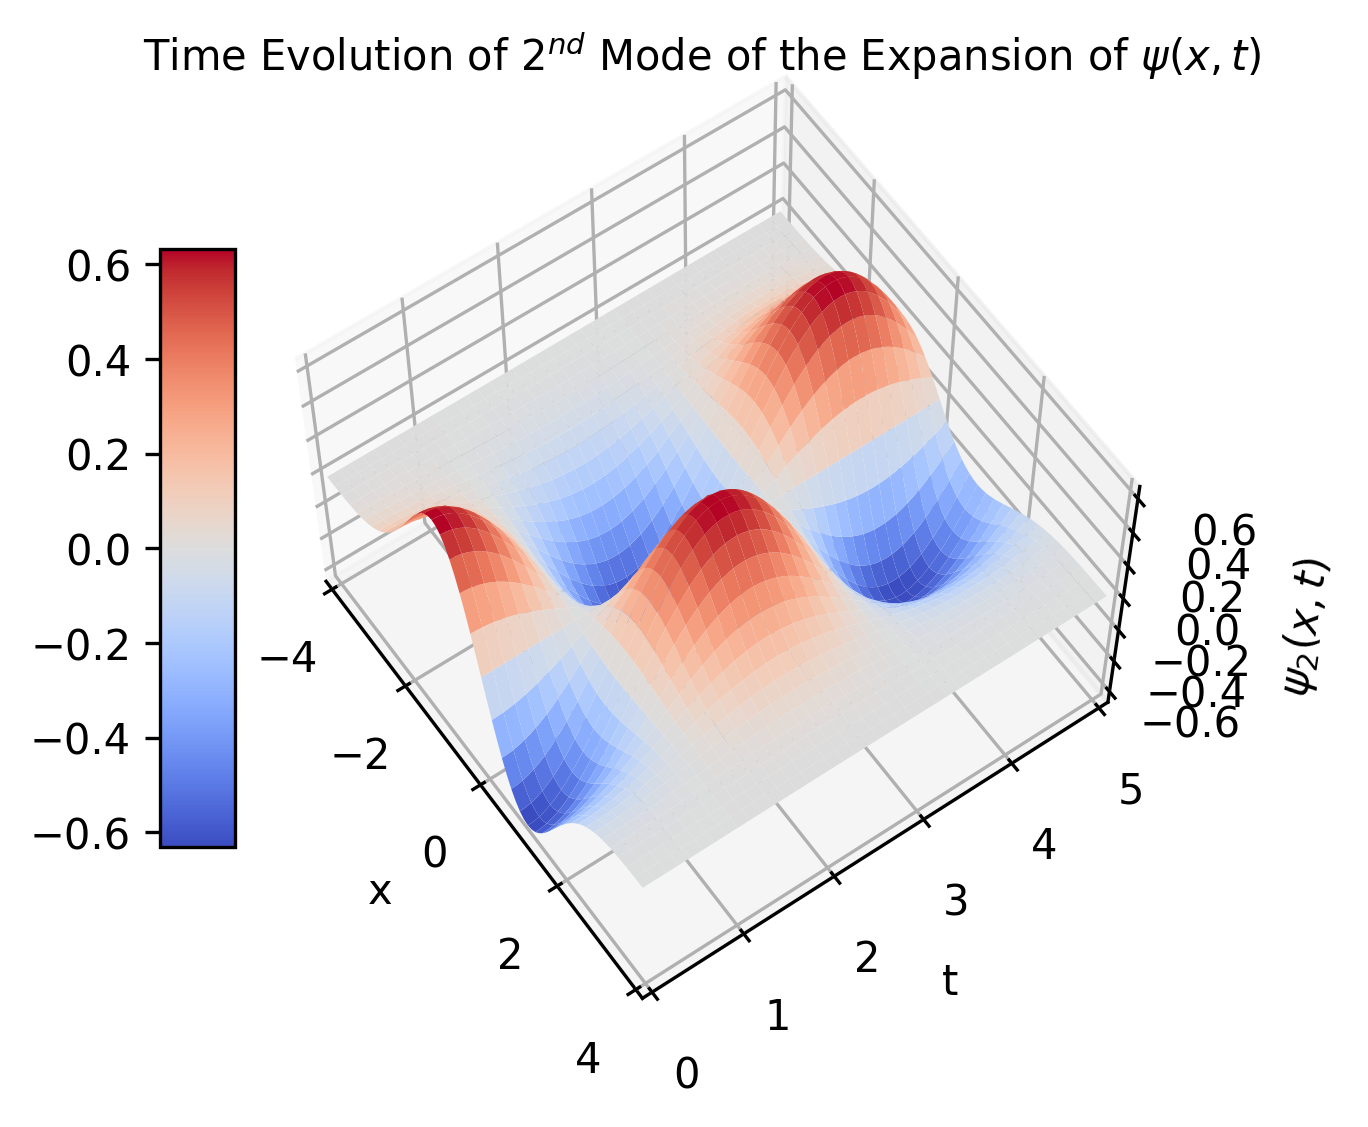

In [4]:
## 1 presentation ##
L = 4

time_steps = 20*L+1
tspan = np.linspace(0,5,time_steps)
xspan = np.linspace(-L,L,20*L + 1)

X,T = np.meshgrid(xspan, tspan)
mode = phi_n[:,1].reshape(-1,1) @ np.cos(eigs_n[1]*tspan/2).reshape(1,-1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection =  '3d')
surf = ax.plot_surface(X,T,mode.T, lw = 0, cmap = 'coolwarm')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$\psi_2(x,t)$')
ax.set_ylim([0,5])
ax.set_yticks([0,1,2,3,4,5])
ax.set_xlim([-L,L])
ax.set_xticks([-4,-2,0,2,4])
ax.view_init(60,-35)
fig.colorbar(surf, shrink = 0.66, aspect = 8, location = 'left', pad = 0.01)
plt.title('Time Evolution of $2^{nd}$ Mode of the Expansion of $\psi(x,t)$', size = 10)
plt.show()

In [5]:
## 2 ##
L = 4
xspan = np.linspace(-L,L,20*L + 1)
dx = 0.1

A = np.zeros((len(xspan)-2, len(xspan)-2))      ## construct A w/o 1st/last points
for i in range(1,len(xspan)-3):
    A[i,i-1] = -1/dx**2
    A[i,i] = (2/dx**2) + xspan[i+1]**2
    A[i,i+1] = -1/dx**2
A[0,0] = 2/(3*dx**2) + xspan[1]**2
A[0,1] = -2/(3*dx**2)
A[-1,-1] = 2/(3*dx**2) + xspan[-2]**2
A[-1,-2] = -2/(3*dx**2)

lmbd, v = np.linalg.eig(A)

idx = np.argsort(lmbd)
lmbd_sorted = lmbd[idx]
v_sorted = v[:,idx]

phi_n_direct = np.zeros((len(xspan), 5))
for i in range(5):
    phi_n_direct[0,i] = (4*v_sorted[0,i] - v_sorted[1,i])/(3 + 2*dx*np.sqrt(L**2 - lmbd_sorted[i]))                      ## backward for 1st point
    phi_n_direct[1:-1,i] = v_sorted[:,i]
    phi_n_direct[-1,i] = (4*v_sorted[-1,i] - v_sorted[-2,i])/(3 + 2*dx*np.sqrt(L**2 - lmbd_sorted[i]))                  ## forward for last point
    phi_n_direct[:,i] = np.abs(phi_n_direct[:,i]/np.sqrt(sp.integrate.trapz((phi_n_direct[:,i]**2),xspan)))

A7 = phi_n_direct[:,0].reshape(-1,1)
A8 = phi_n_direct[:,1].reshape(-1,1)
A9 = phi_n_direct[:,2].reshape(-1,1)
A10 = phi_n_direct[:,3].reshape(-1,1)
A11 = phi_n_direct[:,4].reshape(-1,1)
A12 = lmbd_sorted[:5].reshape(1,-1)

In [6]:
## 3 ##
def gamma_harmonic(x,y,eps,gamma):
    return [y[1], y[0]*(gamma*(np.abs(y[0]))**2 + x**2 - eps)]

L = 3
gammas = [0.05, -0.05]

xspan = np.linspace(-L, L, int(20*L + 1))
eigs_n_gam = np.zeros((2,2))                        ## stores eig vals
phi_n_gam = np.zeros((int(20*L + 1), 2, 2))             ## stores phi_n
A_values = np.zeros((2,2))

for k, gamma in enumerate(gammas):              ## gamma loop
    eps_start = 0                               ## restart eps_start for new gamma
    A = 0.0001
    for j in range(2):                          ## mode loop
        eps = eps_start
        deps = 0.1
        for i in range(2000):                   ## shooting loop
            y0 = [A, A*np.sqrt(L**2 - eps)]
            sol = sp.integrate.solve_ivp(gamma_harmonic, [-L,L], y0, args = (eps, gamma), t_eval = xspan)

            norm = sp.integrate.trapz(sol.y[0,:]**2,xspan)
            bc_true = sol.y[1,-1]                           ##  "true" right bc
            bc_calc = -sol.y[0,-1]*np.sqrt(L**2 - eps)      ##  calculated right bc

            if np.abs(1 - norm) < 1e-5 and np.abs(bc_true - bc_calc) < 1e-5:
                break
            else:                                           ## update A parameter if conditions not met
                A = A/np.sqrt(norm)

            y0 = [A, A*np.sqrt(L**2 - eps)]
            sol = sp.integrate.solve_ivp(gamma_harmonic, [-L,L], y0, args = (eps, gamma), t_eval = xspan)

            norm = sp.integrate.trapz(sol.y[0,:]**2,xspan)
            bc_true = sol.y[1,-1]                           ##  "true" right bc
            bc_calc = -sol.y[0,-1]*np.sqrt(L**2 - eps)      ##  calculated right bc
            
            if np.abs(bc_true - bc_calc) < 1e-5 and np.abs(1 - norm) < 1e-5:
                break
            else:                                           ## update eps if conditions not met
                if ((-1)**j)*(bc_true - bc_calc) > 0:
                    eps = eps + deps
                else:
                    eps = eps - deps/2
                    deps = deps/2
        eigs_n_gam[k,j] = eps
        phi_n_gam[:,j,k] = sol.y[0,:].reshape(-1)
        A_values[k,j] = A
        eps_start = eps + 0.1                                   ## jumps up over found eigval

A13 = np.abs(phi_n_gam[:,0,0]).reshape(-1,1)
A14 = np.abs(phi_n_gam[:,1,0]).reshape(-1,1)
A15 = eigs_n_gam[0,:].reshape(1,-1)

A16 = np.abs(phi_n_gam[:,0,1]).reshape(-1,1)
A17 = np.abs(phi_n_gam[:,1,1]).reshape(-1,1)
A18 = eigs_n_gam[1,:].reshape(1,-1)

Linear eigenvalues [0.99973579 2.9990026 ]: 
Nonlinear eigenvalues γ [[1.01945133 3.01267338]]: 
Nonlinear eigenvalues -γ [[0.97994614 2.98324356]]:


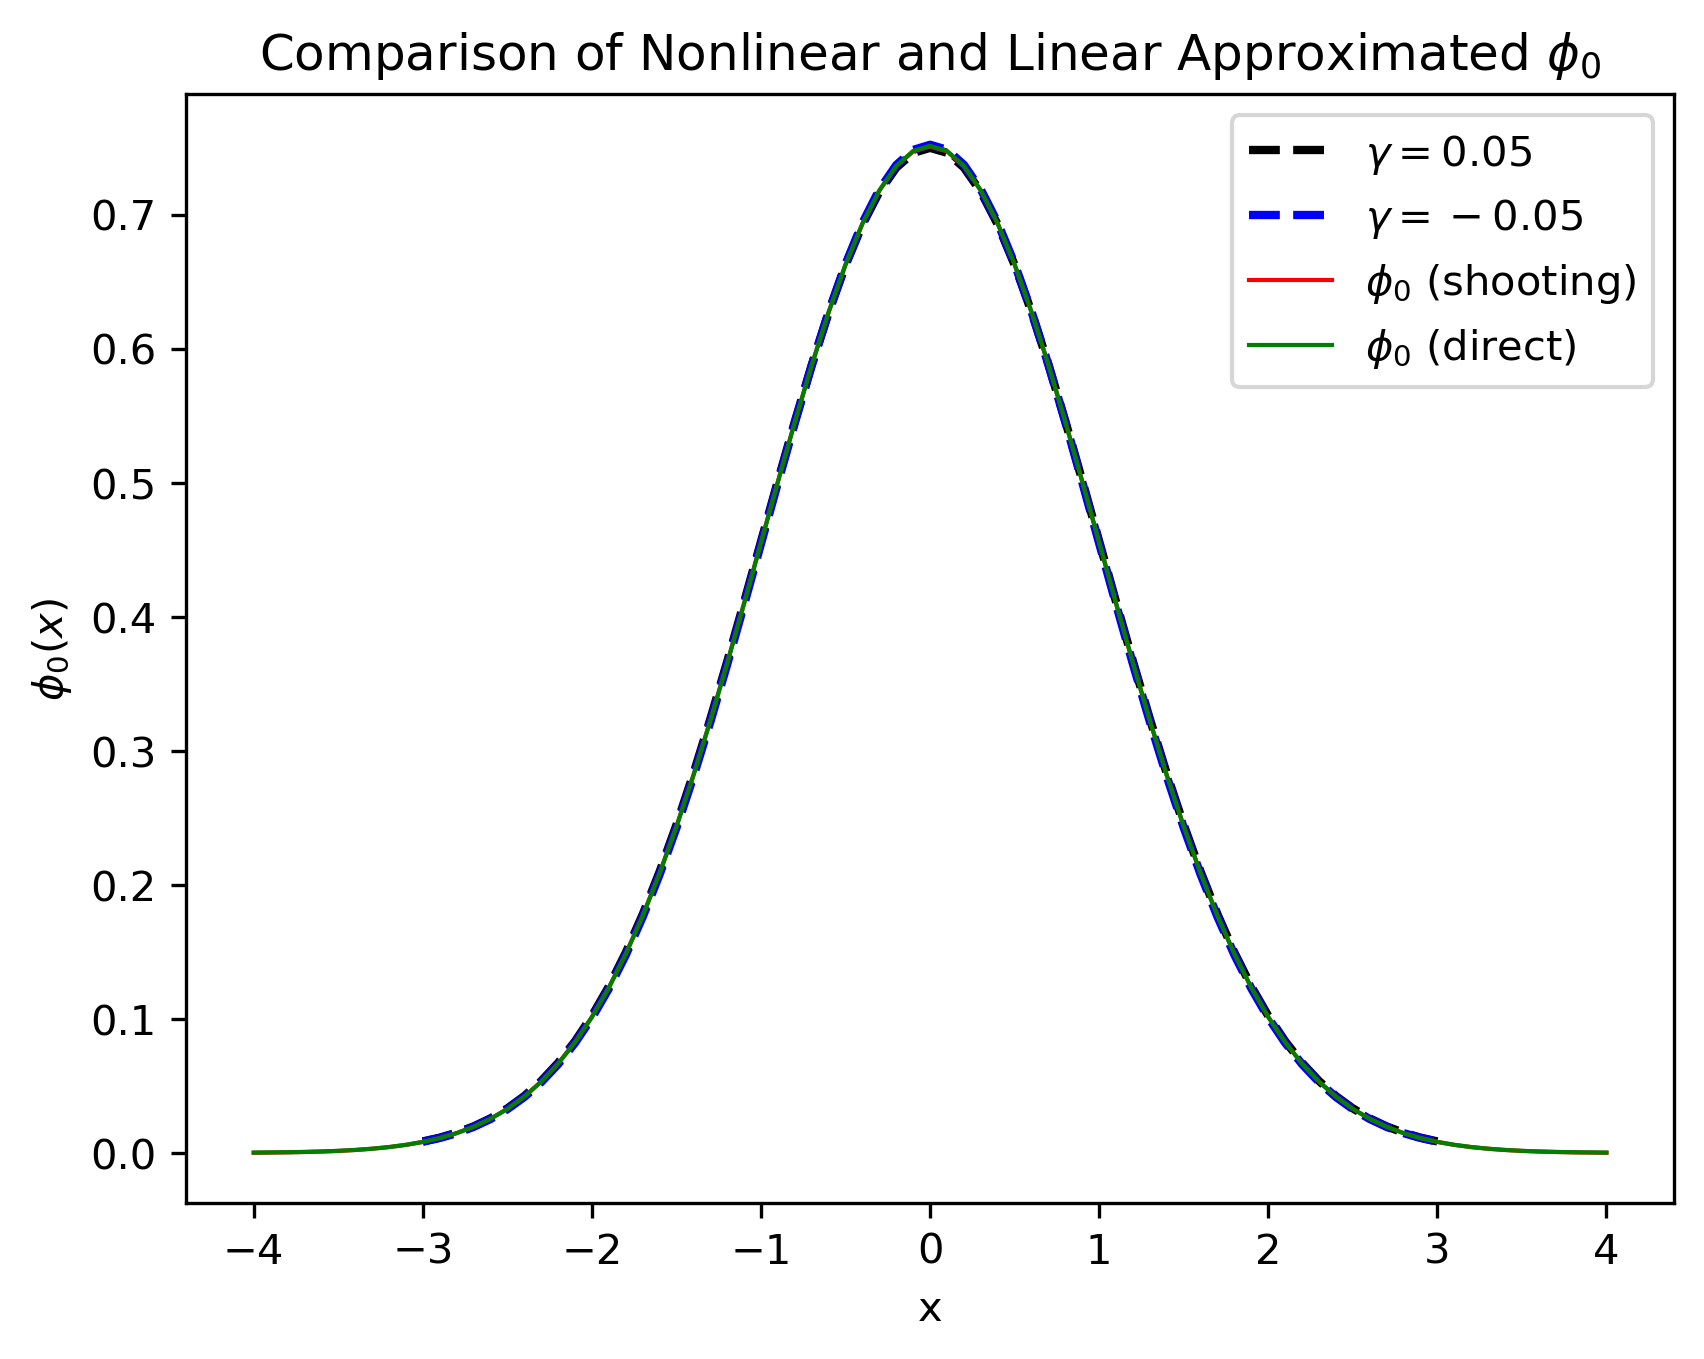

In [24]:
## 3 presentation ##

print(f'Linear eigenvalues {A6[0,:2]}:', f'\nNonlinear eigenvalues γ {A15}:', 
      f'\nNonlinear eigenvalues -γ {A18}:')

plt.plot(xspan, phi_n_gam[:,0,0], 'k--', lw = 2, label = '$\gamma = 0.05$')
plt.plot(xspan, phi_n_gam[:,0,1], 'b--', lw = 2, label = '$\gamma = -0.05$')
plt.plot(np.linspace(-4,4,20*4+1), phi_n[:,0], 'r-', lw = 1, label = '$\phi_0$ (shooting)')
plt.plot(np.linspace(-4,4,20*4+1), phi_n_direct[:,0], 'g-', lw = 1, label = '$\phi_0$ (direct)')
#plt.xlim([-1.1,-0.9])
#plt.ylim([0.63,0.66])
plt.xlabel('x')
plt.ylabel('$\phi_0(x)$')
plt.title('Comparison of Nonlinear and Linear Approximated $\phi_0$')
plt.legend()
plt.show()